https://towardsdatascience.com/predict-customer-churn-in-python-e8cd6d3aaa7

In [236]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [237]:
data = pd.read_csv('Telco-Customer-Churn.csv')
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [238]:
data.drop(columns='customerID', inplace=True)
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [239]:
#Clean and check data
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')
data['tenure'] = data['tenure'].astype("float")

data.isna().any()

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool

In [240]:
data.dropna(subset=['TotalCharges'], inplace=True)
data.isna().any()

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

Let's do some analysis from the dataset before I start doing the predictions

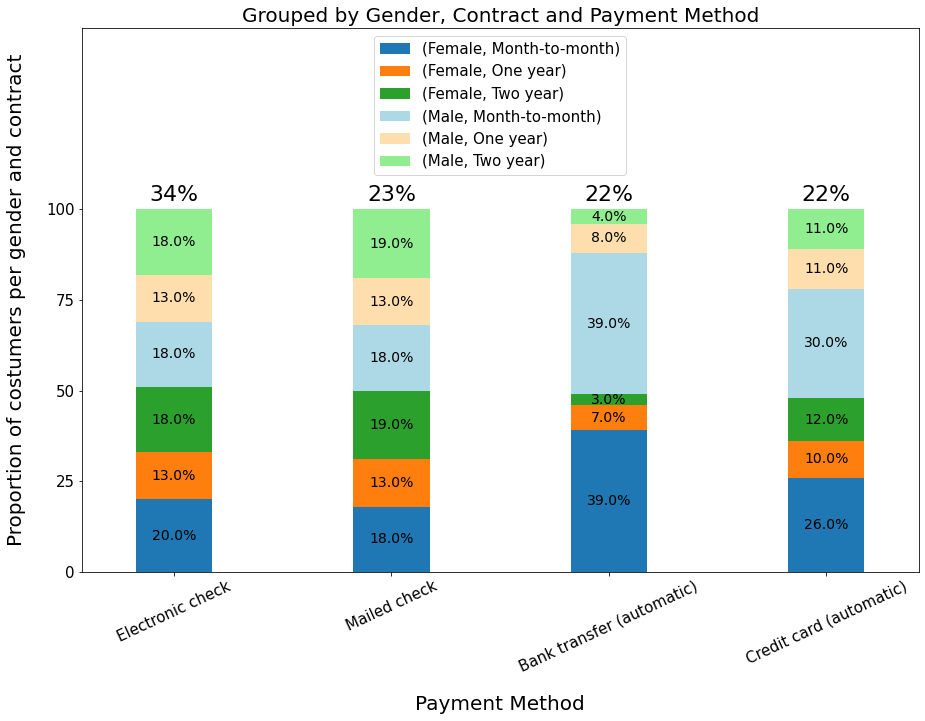

In [241]:
contract_per_payment = data.groupby(['gender', 'Contract', 'PaymentMethod']).size().unstack()
contract_per_payment = round((contract_per_payment/contract_per_payment.sum()).T,2)

payment_methods_percentages = round((data.PaymentMethod.value_counts()/data.PaymentMethod.value_counts().sum())*100,2).tolist()

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize=(15,10))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'lightblue', 'navajowhite', 'lightgreen']
contract_per_payment.plot(ax = ax, kind='bar', width=0.35, stacked=True, color=colors)

x_ticks, x_ticklabels = [0,1,2,3], dict(data.PaymentMethod.value_counts()).keys()
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels, fontsize=15, rotation=25)

y_ticks, y_ticklabels = [0,0.25,0.5,0.75,1], [0,25,50,75,100]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels, fontsize=15)
ax.set_ylim(0,1.5)

ax.set_title('Grouped by Gender, Contract and Payment Method', fontsize = 20)
ax.set_xlabel('Payment Method', labelpad = 20, fontsize = 20)
ax.set_ylabel('Proportion of costumers per gender and contract', labelpad = 20, fontsize = 20)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=14)

for count, value in enumerate(payment_methods_percentages):
    ax.text(count, 
            1.04, 
            '{:.0f}%'.format(value), 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=22)


    
ax.legend(loc='upper center', fontsize=15);

I do the same but based on Gender, Partner and Dependents

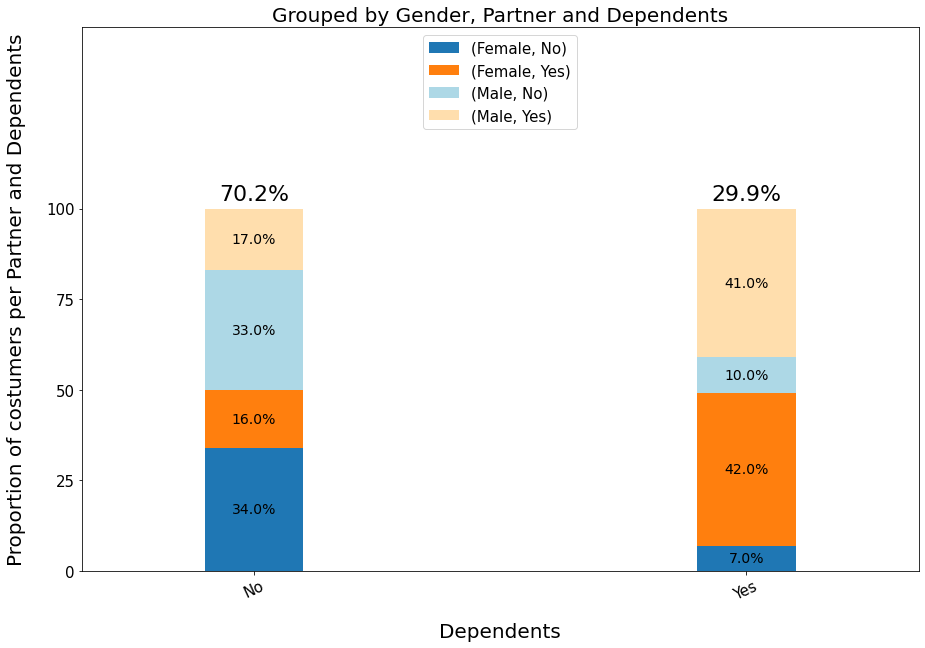

In [242]:
partner_dependents = data.groupby(['gender', 'Partner', 'Dependents']).size().unstack()
partner_dependents = round((partner_dependents/partner_dependents.sum()).T,2)

dependents_percentages = round((data.Dependents.value_counts()/data.Dependents.value_counts().sum())*100,2).tolist()

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize=(15,10))
colors = ['tab:blue', 'tab:orange', 'lightblue', 'navajowhite']
partner_dependents.plot(ax = ax, kind='bar', width=0.2, stacked = True, color=colors)

x_ticks, x_ticklabels = [0,1], dict(data.Dependents.value_counts()).keys()
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels, fontsize=15, rotation=25)

y_ticks, y_ticklabels = [0,0.25,0.5,0.75,1], [0,25,50,75,100]
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels, fontsize=15)
ax.set_ylim(0,1.5)

ax.set_title('Grouped by Gender, Partner and Dependents', fontsize = 20)
ax.set_xlabel('Dependents', labelpad = 20, fontsize = 20)
ax.set_ylabel('Proportion of costumers per Partner and Dependents', labelpad = 20, fontsize = 20)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=14)

for count, value in enumerate(dependents_percentages):
    ax.text(count, 
            1.04, 
            '{:.1f}%'.format(value), 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize=22)


    
ax.legend(loc='upper center', fontsize=15);

<ipython-input-243-442311c9d4ba>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_binarized_columns[col] = le.transform(data_binarized_columns[col])


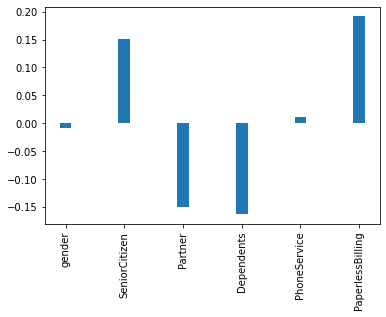

In [243]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

binarized_columns = list()
for x in data.columns:
    if data[x].nunique()<=2:
        binarized_columns.append(x)

data_binarized_columns = data[binarized_columns]
for col in data_binarized_columns.columns:
    le.fit(data_binarized_columns[col])
    data_binarized_columns[col] = le.transform(data_binarized_columns[col])

data_binarized_columns

data_binarized_columns.corrwith(data_binarized_columns['Churn'])[:-1].plot(kind='bar', width=0.2);

<ipython-input-244-614901bbc0e8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_categorical_columns[col] = le.transform(data_categorical_columns[col])


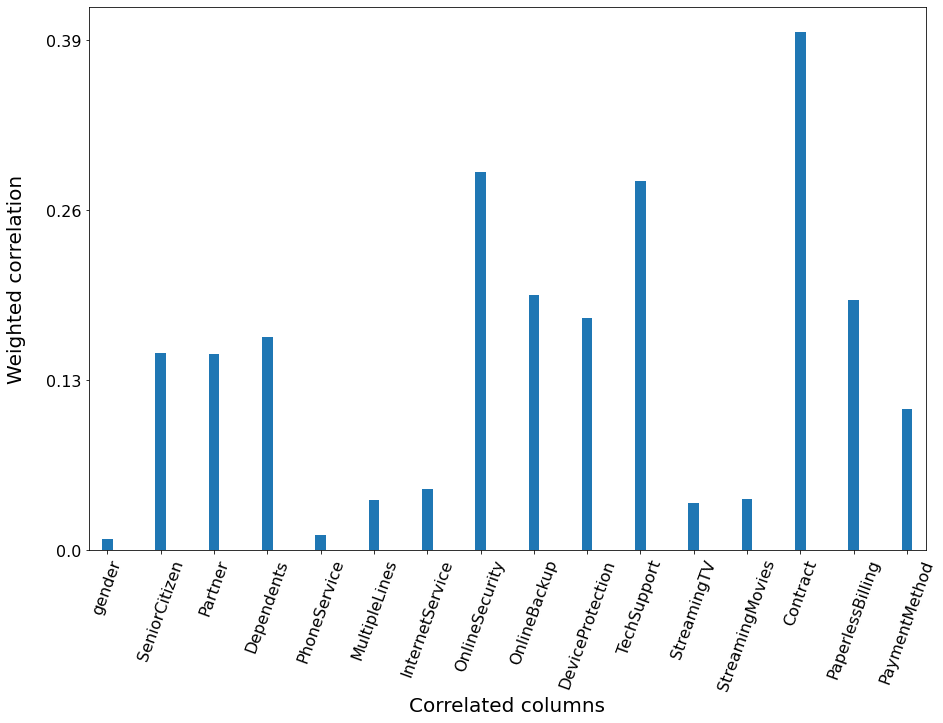

In [244]:
categorical_columns = list()


for x in data.select_dtypes(include=["object_","int64"]).columns:
    categorical_columns.append(x)

data_categorical_columns = data[categorical_columns]
for col in data_categorical_columns.columns:
    le.fit(data_categorical_columns[col])
    data_categorical_columns[col] = le.transform(data_categorical_columns[col])

#data_categorical_columns

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,10))

data_categorical_columns.corrwith(data_categorical_columns['Churn'])[:-1].abs().plot(ax=ax, kind='bar', width=0.2)

correlated_values = dict(data_categorical_columns.corrwith(data_categorical_columns['Churn'])[:-1].abs())
x_ticks = [i for i in range(len(correlated_values.keys()))]
x_ticklabels = correlated_values.keys()
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels, fontsize=16, rotation=70)
ax.set_xlabel('Correlated columns', fontsize=20)

y_ticks = np.arange(0,max(correlated_values.values()),0.13)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=16)
ax.set_ylabel('Weighted correlation', labelpad=20, fontsize=20);

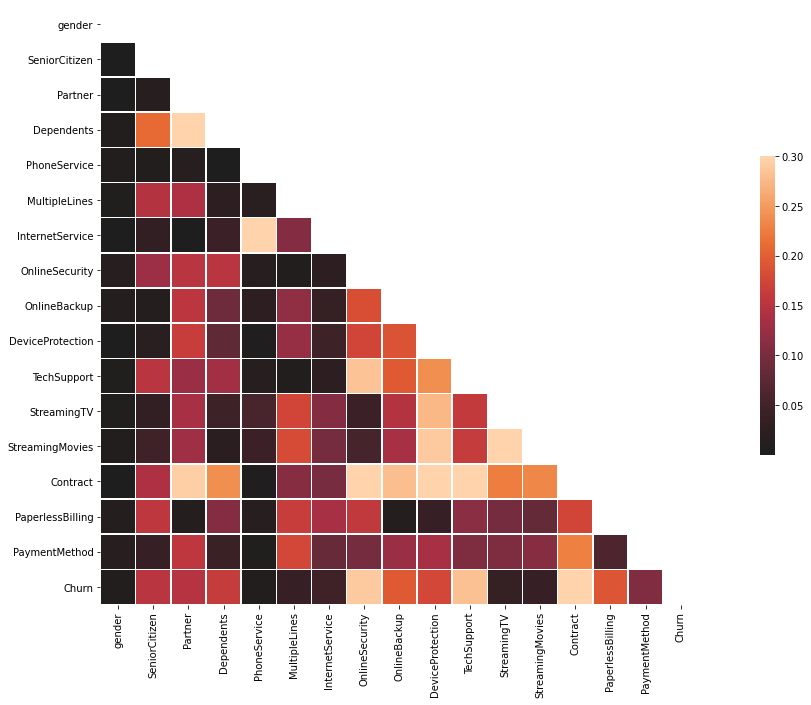

In [245]:
l = data_categorical_columns.corr().abs()

mask = np.zeros_like(l, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(22,11))
sns.heatmap(l, ax=ax, mask=mask, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [246]:
def plot_for_correlations(corr):

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(17,8))
    axList = ax.flatten()

    y_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    x_ticks = [0,1]
    for count, value in enumerate(corr):
        plot_percentages = data.groupby([value, 'Churn']).size().unstack()
        plot_percentages = round((plot_percentages/plot_percentages.sum()).T,2).plot(ax=axList[count], 
                                                                                     stacked=True, 
                                                                                     kind='bar',
                                                                                     width=0.2)
        axList[count].set_xticks(x_ticks)
        axList[count].set_xticklabels(['Yes','No'], fontsize=15, rotation=0)
        axList[count].set_xlabel('Churn', labelpad=20, fontsize=20)
    
        axList[count].set_yticks(y_ticks)
        axList[count].set_yticklabels(np.array(y_ticks)*100, fontsize=15)
        if count==0:
            axList[count].set_ylabel('Proportion per service (%)', labelpad=20, fontsize=20)
    
        axList[count].set_ylim(0,1.4)
        axList[count].legend(loc="upper center", fontsize=18)
    
        for p in axList[count].patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            axList[count].text(x+width/2, 
                               y+height/2, 
                               '{:.1f}%'.format(height*100), 
                               horizontalalignment='center', 
                               verticalalignment='center',
                               fontsize=11)
        
    axList[count].set_title(corr[count], fontsize=17)

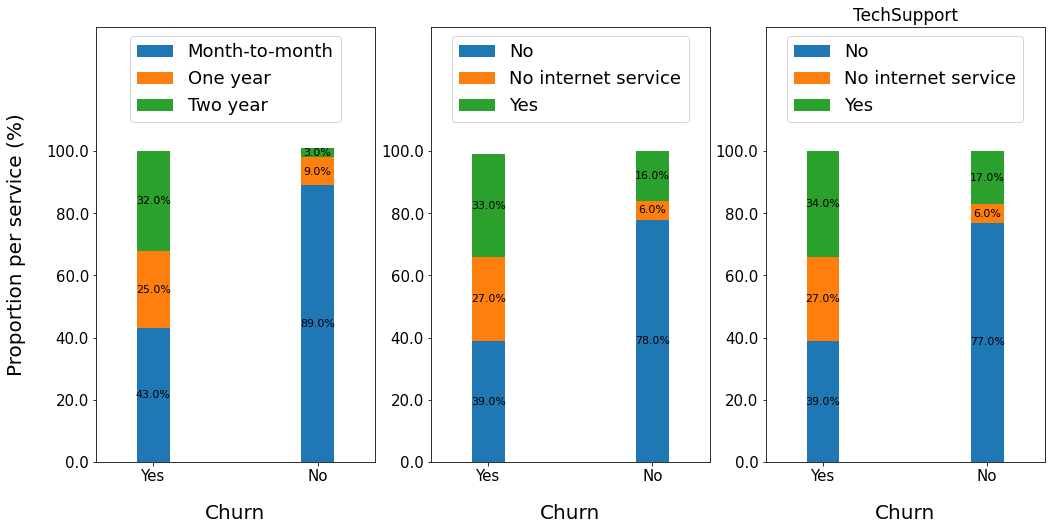

In [247]:
high_correlated = pd.Series(correlated_values).sort_values(ascending=False).head(3)
high_correlated = list(dict(high_correlated).keys())
plot_for_correlations(high_correlated)

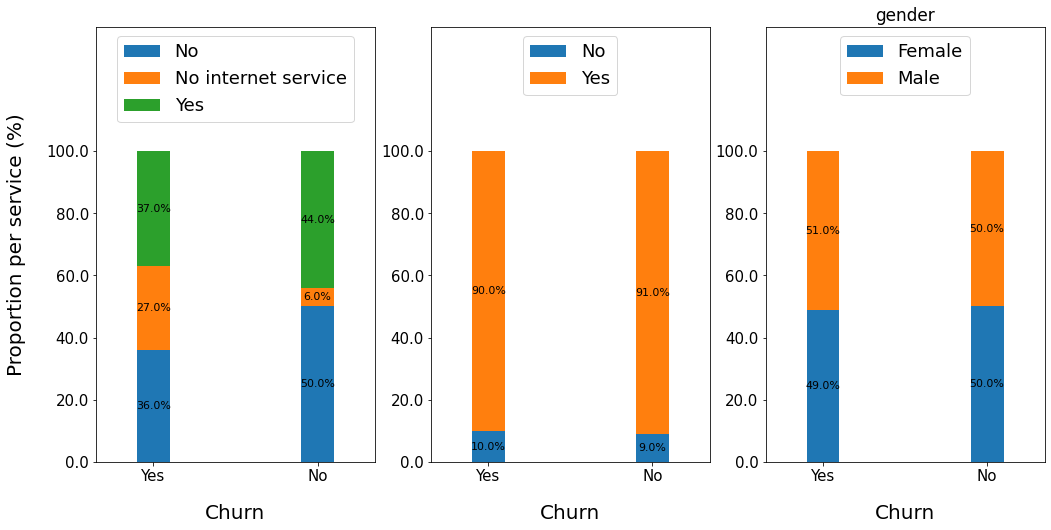

In [248]:
low_correlated = pd.Series(correlated_values).sort_values(ascending=False).tail(3)
low_correlated = list(dict(low_correlated).keys())
plot_for_correlations(low_correlated)

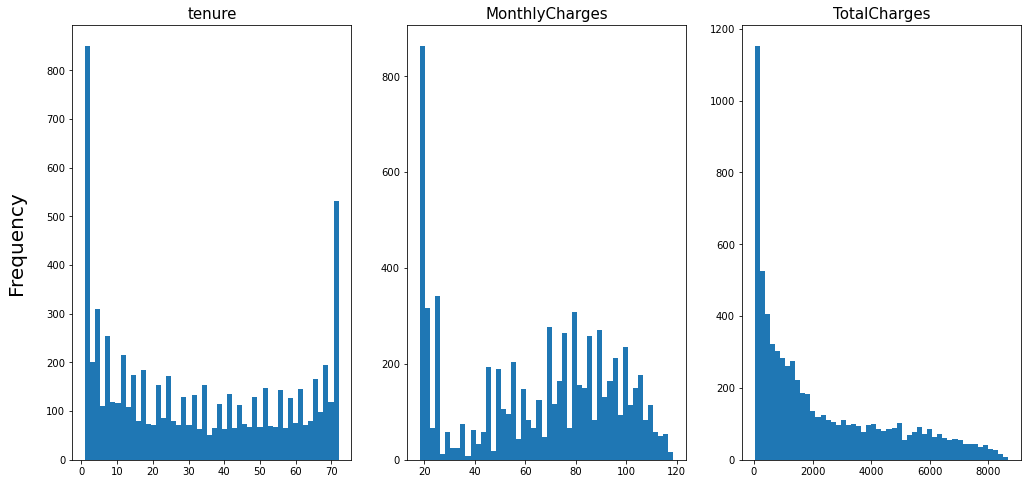

In [249]:
numerical_columns = ['tenure','MonthlyCharges','TotalCharges']

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(17,8))
axList = ax.flatten()

for count, value in enumerate(numerical_columns):
    data[value].plot(ax=axList[count], kind='hist', bins=50)
    if count==0:
        axList[count].set_ylabel('Frequency', labelpad=20, fontsize=20)
    else:
        axList[count].set_ylabel('')
    
    axList[count].set_title(value,fontsize=15)

### Let's apply some Machine Learning techniques for classification

In [250]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler

le = LabelEncoder()
mm = MinMaxScaler()

for col in categorical_columns:
    data[col] = le.fit_transform(data[col])

for col in data.columns[:-1]:
    data[[col]] = mm.fit_transform(data[[col]])

round(data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
gender,7032.0,0.50,0.50,0.00,0.00,1.00,1.00,1.00
SeniorCitizen,7032.0,0.16,0.37,0.00,0.00,0.00,0.00,1.00
Partner,7032.0,0.48,0.50,0.00,0.00,0.00,1.00,1.00
Dependents,7032.0,0.30,0.46,0.00,0.00,0.00,1.00,1.00
tenure,7032.0,32.42,24.55,1.00,9.00,29.00,55.00,72.00
PhoneService,7032.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
MultipleLines,7032.0,0.94,0.95,0.00,0.00,1.00,2.00,2.00
InternetService,7032.0,0.87,0.74,0.00,0.00,1.00,1.00,2.00
OnlineSecurity,7032.0,0.79,0.86,0.00,0.00,1.00,2.00,2.00
OnlineBackup,7032.0,0.91,0.88,0.00,0.00,1.00,2.00,2.00


In [251]:
for col in data.columns[:-1]:
    data[[col]] = mm.fit_transform(data[[col]])

round(data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
gender,7032.0,0.50,0.50,0.0,0.00,1.00,1.00,1.0
SeniorCitizen,7032.0,0.16,0.37,0.0,0.00,0.00,0.00,1.0
Partner,7032.0,0.48,0.50,0.0,0.00,0.00,1.00,1.0
Dependents,7032.0,0.30,0.46,0.0,0.00,0.00,1.00,1.0
tenure,7032.0,0.44,0.35,0.0,0.11,0.39,0.76,1.0
PhoneService,7032.0,0.90,0.30,0.0,1.00,1.00,1.00,1.0
MultipleLines,7032.0,0.47,0.47,0.0,0.00,0.50,1.00,1.0
InternetService,7032.0,0.44,0.37,0.0,0.00,0.50,0.50,1.0
OnlineSecurity,7032.0,0.39,0.43,0.0,0.00,0.50,1.00,1.0
OnlineBackup,7032.0,0.45,0.44,0.0,0.00,0.50,1.00,1.0


In [288]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

X, y = data.drop(columns='Churn'), data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

k = np.arange(1,70,2)
accuracy_results, f1_results, error = list(), list(), list()
for m in k:
    knn = KNeighborsClassifier(n_neighbors=m)
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    accuracy_results.append(accuracy_score(y_pred,y_test))
    f1_results.append(f1_score(y_pred,y_test))
    error.append(1-round(accuracy_score(y_pred,y_test),4))

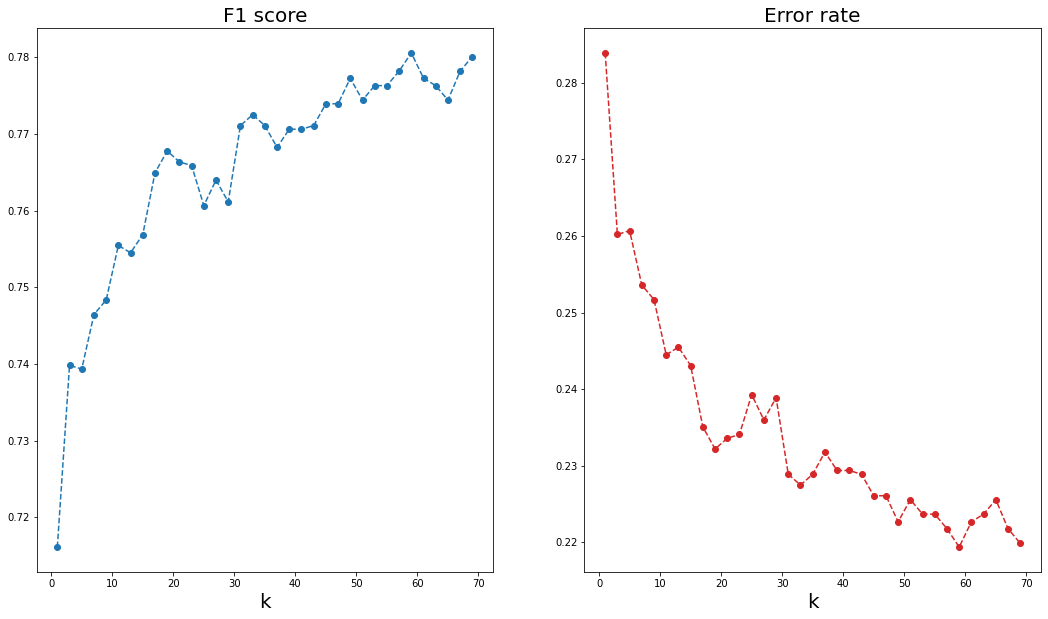

In [289]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,10))
#ax = ax.flatten()
ax1, ax2 = ax[0], ax[1]

ax1.plot(k, accuracy_results, '--o', color='tab:blue')
ax1.set_title('F1 score', fontsize=20)
ax1.set_xlabel('k', fontsize=20)

ax2.plot(k, error, '--o', color='tab:red')
ax2.set_title('Error rate', fontsize=20)
ax2.set_xlabel('k', fontsize=20);

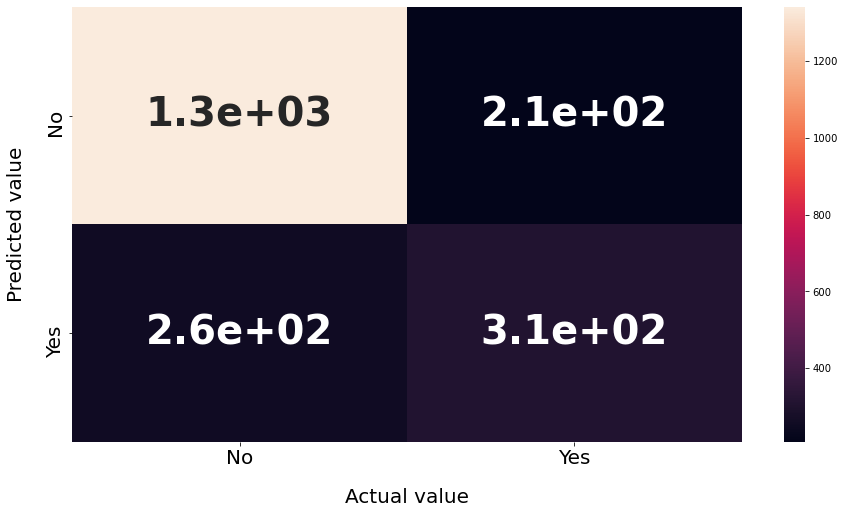

In [308]:
k_selected = k[error.index(min(error))]

knn = KNeighborsClassifier(n_neighbors=k_selected)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,8))
sns.heatmap(ax=ax, data=cm, annot=True, annot_kws={"size": 40, "weight": "bold"})
ticks=['No', 'Yes']
ax.set_xticklabels(ticks, fontsize=20)
ax.set_yticklabels(ticks, fontsize=20)
ax.set_ylabel('Predicted value', labelpad=20, fontsize=20)
ax.set_xlabel('Actual value', labelpad=20, fontsize=20);

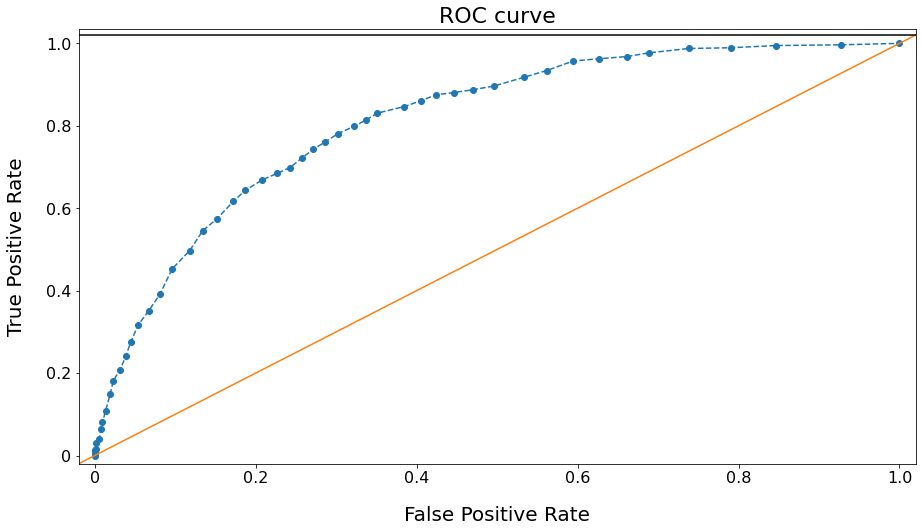

In [316]:
from sklearn.metrics import roc_curve

probs = knn.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, probs)

fig, ax = plt.subplots(1,1,figsize=(15,8))

ax.plot(rf_fpr, rf_tpr, '--o')
ax.plot([-0.02,1.02],[-0.02,1.02], '-')
ax.plot([-0.02,1.02],[1.02,1.02], '-', color='black')

ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks, fontsize=16)

ax.set_yticks(ticks)
ax.set_yticklabels(ticks, fontsize=16)

ax.set_xlim(-0.02,1.02)
ax.set_ylim(-0.02,1.035)

ax.set_xlabel('False Positive Rate', fontsize=20, labelpad=20)
ax.set_ylabel('True Positive Rate', fontsize=20, labelpad=20)
ax.set_title('ROC curve', fontsize=22);

In [342]:
probs = knn.predict_proba(X) 
probs = probs[:, 1]*100

prediction = knn.predict(X)

final_results = zip(data.Churn.tolist(), prediction, np.round(probs,1))

In [343]:
final_results = pd.DataFrame(final_results, columns=['Actual Churn', 'Predicted Churn', 'Propensity to Churn (%)'])
final_results

,Actual Churn,Predicted Churn,Propensity to Churn (%)
0,0,0,44.1
1,0,0,16.9
2,1,0,39.0
3,0,0,3.4
4,1,1,61.0
...,...,...,...
7027,0,0,18.6
7028,0,0,27.1
7029,0,0,27.1
7030,1,1,62.7


In [357]:
indices = np.where(probs>70)

data_again = pd.read_csv('Telco-Customer-Churn.csv')
data_again.drop(columns='customerID', inplace=True)
data_again['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')
data_again['tenure'] = data['tenure'].astype("float")
data_again.dropna(subset=['TotalCharges'], inplace=True)

data_again.iloc[indices[0],:]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
31,Male,1,Yes,No,0.014085,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),95.50,0.018792,No
47,Female,0,No,No,0.014085,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,80.65,0.014465,Yes
55,Male,1,No,No,0.239437,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,0.200063,Yes
237,Male,0,Yes,No,0.239437,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,73.15,0.148529,No
297,Male,1,Yes,No,0.478873,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.80,0.394496,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6837,Male,1,No,No,0.070423,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,79.70,0.055250,No
6862,Female,1,No,No,0.042254,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,88.85,0.040809,Yes
6866,Male,0,No,No,0.000000,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,0.008845,Yes
6878,Female,0,No,No,0.070423,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,89.50,0.063986,Yes
